# Example 3— image manipulation

### Baseline standard Python code

In [1]:
from PIL import Image
import numpy as np
from scipy.signal import convolve2d
import time
import os
import matplotlib.pyplot as plt

In [2]:
def sharpen_image_color(image):
    # Start timing
    start_time = time.time()

    # Convert image to RGB in case it's not already
    image = image.convert('RGB')

    # Define a sharpening kernel
    kernel = np.array(
        [
            [0, -1, 0],
            [-1, 5, -1],
            [0, -1, 0]
        ]
    )

    # Convert image to numpy array
    image_array = np.array(image)

    # Debugging: Check input values
    print("Input array values: Min =", image_array.min(), "Max =", image_array.max())

    # Prepare an empty array for the sharpened image
    sharpened_array = np.zeros_like(image_array)

    # Apply the convolution kernel to each channel (assuming RGB image)
    for i in range(3):
        channel = image_array[:, :, i]
        # Perform convolution
        convolved_channel = convolve2d(channel, kernel, mode='same', boundary='wrap')

        # Clip values to be in the range [0, 255]
        convolved_channel = np.clip(convolved_channel, 0, 255)

        # Store back in the sharpened array
        sharpened_array[:, :, i] = convolved_channel.astype(np.uint8)

    # Debugging: Check output values
    print("Sharpened array values: Min =", sharpened_array.min(), "Max =", sharpened_array.max())

    # Convert array back to image
    sharpened_image = Image.fromarray(sharpened_array)

    # End timing
    duration = time.time() - start_time
    print(f"Processing time: {duration:.4f} (sec)")

    return sharpened_image

Input array values: Min = 0 Max = 255
Sharpened array values: Min = 0 Max = 255
Processing time: 2.8411 (sec)


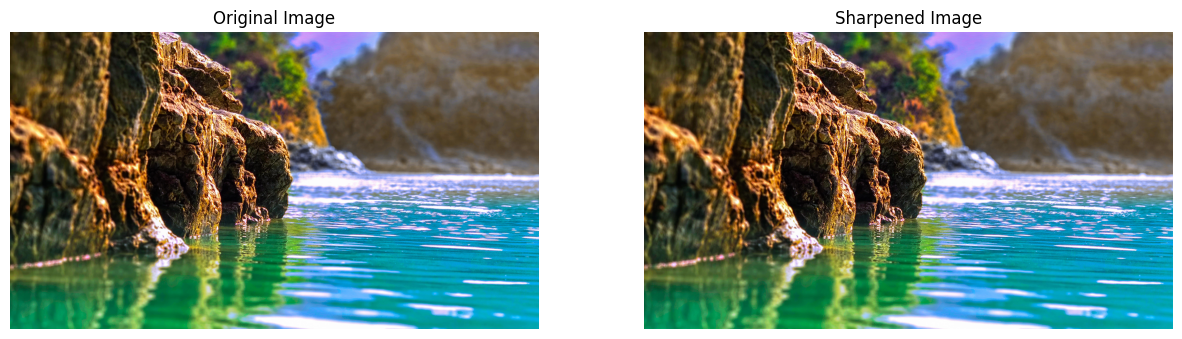

In [3]:
# Correct path for WSL2 accessing Windows filesystem
image_path = './test-images/background.jpg'

image = Image.open(image_path)

# Sharpen the image
sharpened_image = sharpen_image_color(image)

if sharpened_image:
    # Show using PIL's built-in show method (for debugging)
    #sharpened_image.show(title="Sharpened Image (PIL Show)")

    # Display the original and sharpened images using Matplotlib
    fig, axs = plt.subplots(1, 2, figsize=(15, 7))

    # Original image
    axs[0].imshow(image)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    # Sharpened image
    axs[1].imshow(sharpened_image)
    axs[1].set_title("Sharpened Image")
    axs[1].axis('off')

    # Show both images side by side
    plt.show()
else:
    print("Failed to generate sharpened image.")

In [4]:
%load_ext Cython

In [33]:
%%cython
# cython: language_level=3
# distutils: define_macros=NPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION

import numpy as np
cimport numpy as np
import cython

@cython.boundscheck(False)
@cython.wraparound(False)
def sharpen_image_cython(np.ndarray[np.uint8_t, ndim=3] image_array):
    # Define sharpening kernel
    cdef int kernel[3][3]
    kernel[0][0] = 0
    kernel[0][1] = -1
    kernel[0][2] = 0
    kernel[1][0] = -1
    kernel[1][1] = 5
    kernel[1][2] = -1
    kernel[2][0] = 0
    kernel[2][1] = -1
    kernel[2][2] = 0

    # Declare variables outside of loops
    cdef int height = image_array.shape[0]
    cdef int width = image_array.shape[1]
    cdef int channel, i, j, ki, kj
    cdef int value

    # Prepare an empty array for the sharpened image
    cdef np.ndarray[np.uint8_t, ndim=3] sharpened_array = np.zeros_like(image_array)

    # Convolve each channel separately
    for channel in range(3):  # Iterate over RGB channels
        for i in range(1, height - 1):
            for j in range(1, width - 1):
                value = 0  # Reset value at each pixel
                # Apply the kernel
                for ki in range(-1, 2):
                    for kj in range(-1, 2):
                        value += kernel[ki + 1][kj + 1] * image_array[i + ki, j + kj, channel]
                # Clip values to be between 0 and 255
                sharpened_array[i, j, channel] = min(max(value, 0), 255)

    return sharpened_array

In [34]:
# Python part of the code
from PIL import Image
import cv2
import numpy as np
import time as py_time  # Renaming the Python time module to avoid conflict
import matplotlib.pyplot as plt

In [38]:
# Load the input image
image_path = './test-images/background.jpg'
image = Image.open(image_path)

# Convert the image to a NumPy array
image_array = np.array(image)

# Time the sharpening with Cython
start_time = py_time.time()
sharpened_array = sharpen_image_cython(image_array)
cython_time = py_time.time() - start_time

# Convert back to an image for displaying


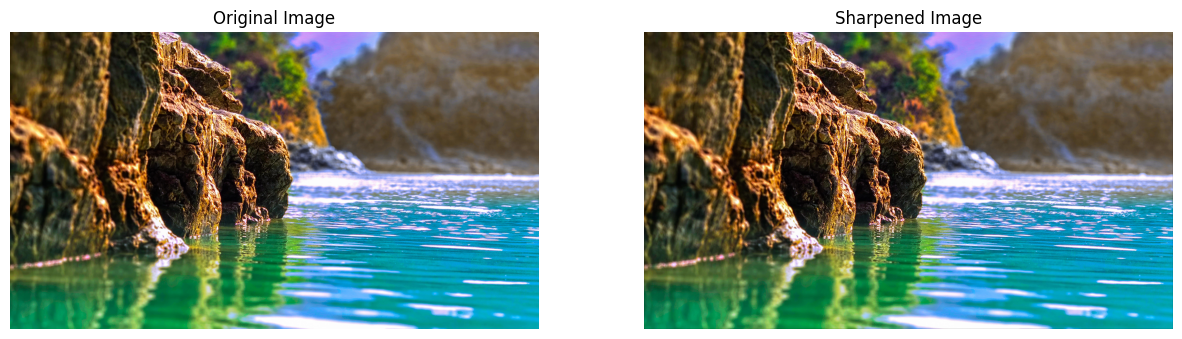

Processing time with Cython: 0.1478 (sec)


In [39]:
sharpened_image = Image.fromarray(sharpened_array)
image = Image.fromarray(image_array)

# Display the original and sharpened images using Matplotlib
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

# Original image
axs[0].imshow(image)
axs[0].set_title("Original Image")
axs[0].axis('off')

# Sharpened image
axs[1].imshow(sharpened_image)
axs[1].set_title("Sharpened Image")
axs[1].axis('off')

plt.show()

# Print the time taken for Cython processing
print(f"Processing time with Cython: {cython_time:.4f} (sec)")